This notebook shows the analysis of the 29 diamonds whos results are in the thesis.

In [1]:
%load_ext autoreload
%autoreload 1
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import os,sys,inspect
import sklearn as sk
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
%aimport analysis
%aimport learning
%aimport NV_generator

In [2]:
diamonds = []
num_diamonds = 29
for diamond_num in range(num_diamonds):
    diamond = learning.load_obj("diamonds/diamond_" + str(diamond_num))
    diamonds.append(diamond)

In [3]:
B_field = 0.0403555 # Teslas
gam_c = 67.262 * 10 ** 6 # Gyromagnetic ratio for a single c13 nucleus in rad s-1 T-1
ms = 1
omega_larmor = -1 * ms * gam_c * B_field

In [99]:
guess_scaler = learning.load_obj("classifiers/scaler_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/scaler_svm_rbfguess_limited_3220_C1_29diamonds")scaler_svm_linear_di3220_29diamond
guess_clf = learning.load_obj("classifiers/clf_svm_rbf_di3220_29diamonds_cxABe")#("classifiers/clf_svm_rbfguess_limited_3220_C1_29diamonds")
num_correct_list, num_incorrect_list = [], []
As_list, Bs_list = [], []
guess_As_list, guess_Bs_list = [], []
dips_measured = []
for diamond_ind in range(len(diamonds)):
    print "diamond_ind: ", diamond_ind
    diamond = diamonds[diamond_ind]
    tau = diamond["tau"]
    data = diamond["data"]
    N = diamond["N"]
    dip_inds = diamond["dip_inds"]
    windows = diamond["windows"]
    min_dip_ind = 3220
    measure_dii = filter(lambda dii: dip_inds[dii] >= min_dip_ind, range(len(dip_inds)))
    print "dips measured: ", len(measure_dii)
    dips_measured.append(len(measure_dii))
    spin_dict = {}
    for dii in measure_dii:
        if diamond["good_fits"][dii]:
            dip_ind = dip_inds[dii]
            res_tau = tau[dip_ind]
            for phi, x in zip(diamond["phis_list"][dii], diamond["xs_list"][dii]):
                for omega_tilde, cosphi in analysis.calc_omega_tilde(phi, x, res_tau, omega_larmor):
                    A, B = analysis.calc_A_B(cosphi, res_tau, omega_larmor, omega_tilde)
                    if analysis.valid_A_B(A, B):
                        if (dip_ind, phi, x) in spin_dict:
                            spin_dict[(dip_ind, phi, x)] += [(A, B, cosphi)]
                        else:
                            spin_dict[(dip_ind, phi, x)] = [(A, B, cosphi)]
    def guess_classifier(features):
        return guess_clf.predict(guess_scaler.transform([features]))
    guess_As, guess_Bs, dataerrs, _, _, _, _ = analysis.choose_spin_guesses(spin_dict, N, omega_larmor, tau, data,
                                                                guess_classifier, x_min = 1, error_fun = analysis.squared_error)
    cluster_As, cluster_Bs, cluster_dataerrs = analysis.cluster_spin_guesses(guess_As, guess_Bs, dataerrs, eps = .075, min_samples = 1)
    As, Bs, num_remove = cluster_As, cluster_Bs, 1
    while num_remove <= 2:
        As, Bs, num_remove = analysis.remove_spins(As, Bs, N, omega_larmor, tau, data, num_remove = num_remove, error_fun = analysis.squared_error)
    As_list.append(As)
    Bs_list.append(Bs)
    guess_As_list.append(guess_As)
    guess_Bs_list.append(guess_Bs)
    
    print "num_removed: ", len(cluster_As) - len(As)
    num_correct = 0
    spins = set(zip(diamond["A"], np.abs(diamond["B"])))
    for A, B in zip(As, np.abs(Bs)):
        for spin in spins:
            if learning.is_fit(A, B, spin, A_acc = .5, B_acc = 2):
                num_correct = num_correct + 1
                spins.remove(spin)
                break
    num_incorrect = len(As) - num_correct
    num_correct_list.append(num_correct)
    num_incorrect_list.append(num_incorrect)
    print "correct: ", num_correct, "incorrect: ", len(As) - num_correct

diamond_ind:  0
dips measured:  374
num_removed:  4
correct:  19 incorrect:  6
diamond_ind:  1
dips measured:  429
num_removed:  0
correct:  21 incorrect:  4
diamond_ind:  2
dips measured:  431
num_removed:  0
correct:  16 incorrect:  9
diamond_ind:  3
dips measured:  357
num_removed:  1
correct:  14 incorrect:  2
diamond_ind:  4
dips measured:  426
num_removed:  1
correct:  11 incorrect:  2
diamond_ind:  5
dips measured:  406
num_removed:  1
correct:  22 incorrect:  3
diamond_ind:  6
dips measured:  406
num_removed:  0
correct:  14 incorrect:  2
diamond_ind:  7
dips measured:  375
num_removed:  0
correct:  14 incorrect:  1
diamond_ind:  8
dips measured:  390
num_removed:  0
correct:  16 incorrect:  1
diamond_ind:  9
dips measured:  445
num_removed:  0
correct:  18 incorrect:  7
diamond_ind:  10
dips measured:  388
num_removed:  0
correct:  10 incorrect:  0
diamond_ind:  11
dips measured:  385
num_removed:  0
correct:  10 incorrect:  3
diamond_ind:  12
dips measured:  375
num_removed: 

analysis.py:61: RuntimeWarning: invalid value encountered in sqrt
  B = np.sqrt((1 - mz ** 2)) * omega_tilde


In [100]:
np.mean(num_correct_list), np.mean(num_incorrect_list)

(15.0, 2.7241379310344827)

In [2]:
#results_dict = {"As_list" : As_list, "Bs_list" : Bs_list,
#                "num_correct_list" : num_correct_list, "num_incorrect_list" : num_incorrect_list, "dips_measured" : dips_measured}
#learning.store_obj(results_dict, "results/results_di3220_29diamonds_cxABe_x1")
results_dict = learning.load_obj("results/results_di3220_29diamonds_cxABe_x1")
As_list = results_dict["As_list"]
Bs_list = results_dict["Bs_list"]
num_correct_list = results_dict["num_correct_list"]
num_incorrect_list = results_dict["num_incorrect_list"]
dips_measured = results_dict["dips_measured"]
#print np.mean(results_dict["num_correct_list"])#, num_correct_list
#print results_dict["num_incorrect_list"]#, num_incorrect_list
#As_list = results_dict["As_list"]
#Bs_list = results_dict["Bs_list"]

In [5]:
np.mean(np.array(dips_measured) * 128 + 5100)

55298.068965517239

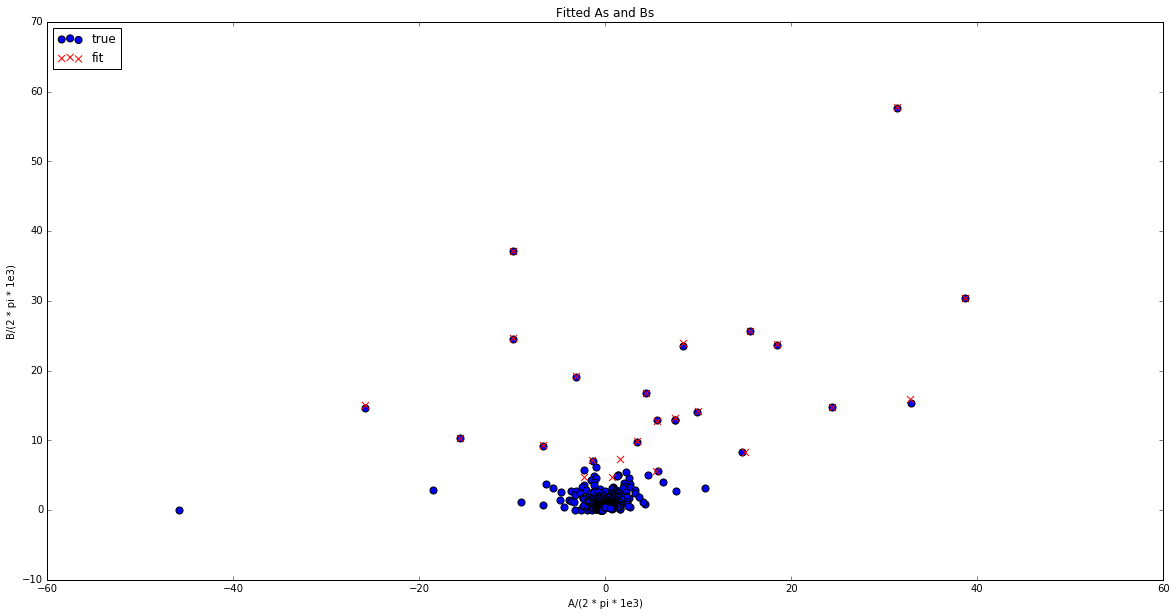

In [83]:
%matplotlib inline
diamond_ind = 21
plt.figure(figsize=(20,10))
plt.title("Fitted As and Bs")
plt.xlabel("A/(2 * pi * 1e3)")
plt.ylabel("B/(2 * pi * 1e3)")
plt.scatter(diamonds[diamond_ind]["A"]/analysis.mag, np.abs(diamonds[diamond_ind]["B"])/analysis.mag, c='b', marker = 'o', s = 50, label = 'true')
plt.scatter(As_list[diamond_ind]/analysis.mag, np.abs(Bs_list[diamond_ind])/analysis.mag, c='r', marker = 'x', s = 50, label = 'fit')
plt.legend(loc=2)
plt.show()